
# ***Previsão de vendas***

*DS: Carlos Silva, WIMyD*

----


# 🎯 Alvo
Montar a previsão de como as vendas se comportarão no próximo mês para gerenciar estoque e fazer estimativa de receita.
___________



# 💭Proposta
___
1. Coleta e preparação dos dados (ETL):
    - Coletar tabela fonte de dados.
    - Transformar os dados em em série temporal.
    - Verificar a qualidade dos dados, procurando por lacunas, dados faltantes ou outliers.
    - Realizar pré-processamento, como preenchimento de dados faltantes ou remoção de outliers.
___
2. Análise exploratória de dados (EDA):
    - Vizualizar a série temporal para entender sua estrutura e padrões.
    - Calcular estatísticas descritivas, como média, mediana, desvio padrão, etc.
    - Identificar tendências, sazonalidades ou padrões cíclicos presentes nos dados.
    - Verificar a presença de autocorrelação, ou seja, se os valores passados influenciam os futuros.
___
3. Decomposição da série temporal:
    - Separar a série temporal em componentes distintos, como tendência, sazonalidade e componente de erro.
    - Utilizar métodos como a decomposição aditiva (quando os componentes são somados) ou multiplicativa (quando são multiplicados).
___
4. Modelagem:
    - Dividir os dados em conjunto de treinamento e conjunto de teste, reservando uma parte dos dados para avaliação posterior do desempenho do modelo.
    - Parametrizar o modelo Prophet.
    - Capturar de dados e testes de modelagem usando MLFlow  (MLOps dos modelos).
    - Validar o modelo usando os dados de teste, calculando métricas de desempenho como erro médio absoluto (MAE), erro médio quadrático (RMSE) ou coeficiente de determinação (R²). Considerar validação cruzada.
___ 
5. Avaliação e refinamento:
    - Avaliar o desempenho do modelo de previsão com base nas métricas escolhidas.
    - Se necessário, otimização de parâmetros.
    - Repita os passos anteriores, se necessário, até obter um modelo adequado.
___
6. Previsão:
    - Utilize o modelo ajustado para fazer previsões futuras da série temporal.
    - Avalie a precisão das previsões comparando-as com os valores reais observados, se disponíveis.

# 📚 Imports

In [2]:
# Pacotes para processamento de dados
import pandas as pd
import numpy as np

#Pacotes para vizualisação de dados
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes para MLOps
import mlflow
from pathlib import Path

# 💽 Dataset

In [3]:
orders = pd.read_csv("../data/raw/orders_dataset_raw.csv",
                        #nrows=100,
                        dtype={'order_item_id': str},sep=",",
                        parse_dates = ['order_approved_at'],usecols=['order_id','order_approved_at']
                        )              
orders.info(show_counts=True)
display(orders.head())
print(orders.isnull().sum())
#Teste

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           99441 non-null  object        
 1   order_approved_at  99281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,order_id,order_approved_at
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29


order_id               0
order_approved_at    160
dtype: int64


# ⚙️ ETL


In [4]:
def AgregateDf(df,columns,DateCol,setDateName="ds"):
    #Existem várias ordens de compra executadas por dia, essa função calcula o total diário.
    df = df[columns].copy()
    
    df[DateCol] = pd.to_datetime(df[DateCol]).dt.date
    df = df.groupby(DateCol,as_index=False).count()
    df.columns = [ setDateName,"count"]
    df[setDateName] = pd.to_datetime(df[setDateName]).dt.date
    return df.sort_values(setDateName)

def CleanDiffDaysGap(df,DateCol='ds'):
    df['diferenca_dias'] = df[DateCol].diff().dt.days
    StartSiseDf = len(df)
    StartSliceClean= df[df['diferenca_dias']>7.0]['ds'].max()
    df = df[df['ds']>=StartSliceClean].copy()
    FinishSiseDf = len(df)
    ChangeCut = 1-(FinishSiseDf/StartSiseDf)
    print(f"O dataset diminuiu em {ChangeCut:.0%}")
    df.drop(columns='diferenca_dias',inplace=True)
    return df

def InterpolateSerie (df,DateCol='ds',InterpolateCol = 'count', order = 7):
    df = df.copy()
    df.set_index(DateCol,inplace=True)
    df =df.asfreq('D')
    df[InterpolateCol] = df[InterpolateCol].interpolate(method='linear', order=order)
    return df



orders.dropna(subset=['order_approved_at'],inplace=True)    
orders_daily = AgregateDf(orders,['order_id','order_approved_at'],'order_approved_at')
orders_daily = CleanDiffDaysGap(orders_daily,DateCol='ds')
orders_daily = InterpolateSerie(orders_daily,DateCol='ds')
orders_daily.columns=['Qt_Pedidos'] #Posso colocar isso dentro da função
orders_daily.to_csv("C:\WIMYD\MasterOfDices\data\processed\process01_daily_orders_clean.csv")
orders_daily

O dataset diminuiu em 2%


,Qt_Pedidos
ds,
2017-01-05,3.0
2017-01-06,3.0
2017-01-07,33.0
2017-01-08,4.0
2017-01-09,4.0
...,...
2018-08-30,12.2
2018-08-31,9.4
2018-09-01,6.6


# 📊EDA

## 📈 Série temporal de vendas

Os dados parecem irregulares com uma quebra no padrão sazonal semanal depois '2018-08-25, o padrão é os pedidos ficarem dentro da semana em uma queda de 5 dias e depois uma alta abrupta. Depois dessa data os pedidos entram em um queda de mais de 10 dias. Por conta disso decidi extrair eles da modelagem por conta da possibilidade de dados incompletos. Nesse caso é interessante ver com o cliente e auditar a base de dados.

In [5]:
px.line(orders_daily,
        y='Qt_Pedidos',
        #x='date',
        title="Série temporal de vendas",
        labels={"ds": "Data", "Qt_Pedidos": "Quantidade de Pedidos"}
        ).show()

In [6]:
fig = px.line(orders_daily.loc['2018-07-01':],
        y='Qt_Pedidos',
        #x='date',
        title="Série temporal de vendas - Últimos 17 dias e marcações de sazonalidade de queda semanal",
        labels={"ds": "Data", "Qt_Pedidos": "Quantidade de Pedidos"}
        )

fig.add_vline(x='2018-08-07')
fig.add_vline(x='2018-08-12')

fig.add_vline(x='2018-08-20')
fig.add_annotation(x='2018-08-20', y=444, text="Alta     ")

fig.add_vline(x='2018-08-25')
fig.add_annotation(x='2018-08-25', y=81, text="Baixa     ")


fig.add_annotation(x='2018-08-30', y=15, text="Zona de queda")

fig.show()

In [7]:
orders_daily = orders_daily.loc[:'2018-08-25']
orders_daily

,Qt_Pedidos
ds,
2017-01-05,3.0
2017-01-06,3.0
2017-01-07,33.0
2017-01-08,4.0
2017-01-09,4.0
...,...
2018-08-21,292.0
2018-08-22,183.0
2018-08-23,146.0


## Engenharia de variáveis

Adicionando dados temporais

In [8]:
orders_eda=orders_daily.copy()
orders_eda.reset_index(inplace=True)
orders_eda['Day_Week'] = orders_eda['ds'].dt.weekday
orders_eda['Day_Month'] = orders_eda['ds'].dt.day
orders_eda['Day_Year'] = orders_eda['ds'].dt.dayofyear
orders_eda['Week'] = orders_eda['ds'].dt.isocalendar().week 
orders_eda['Month'] = orders_eda['ds'].dt.month
orders_eda['Quarter'] = orders_eda['ds'].dt.quarter
orders_eda['Year'] = orders_eda['ds'].dt.year
orders_eda.sort_values('ds', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)
orders_eda['Mes_ano'] = orders_eda['ds'].to_numpy().astype('datetime64[M]')

## Informações gerais
Ficou evidênciado uma marcação semanal principalmente na Terça, com valores médios altos e domingo com valores médios baixos.
Na terça os valores são elevados porém os mais dispersos, o segundo maior é  quarta porém menos disperso que terça.
Domingo além das média menores também é menos disperso.

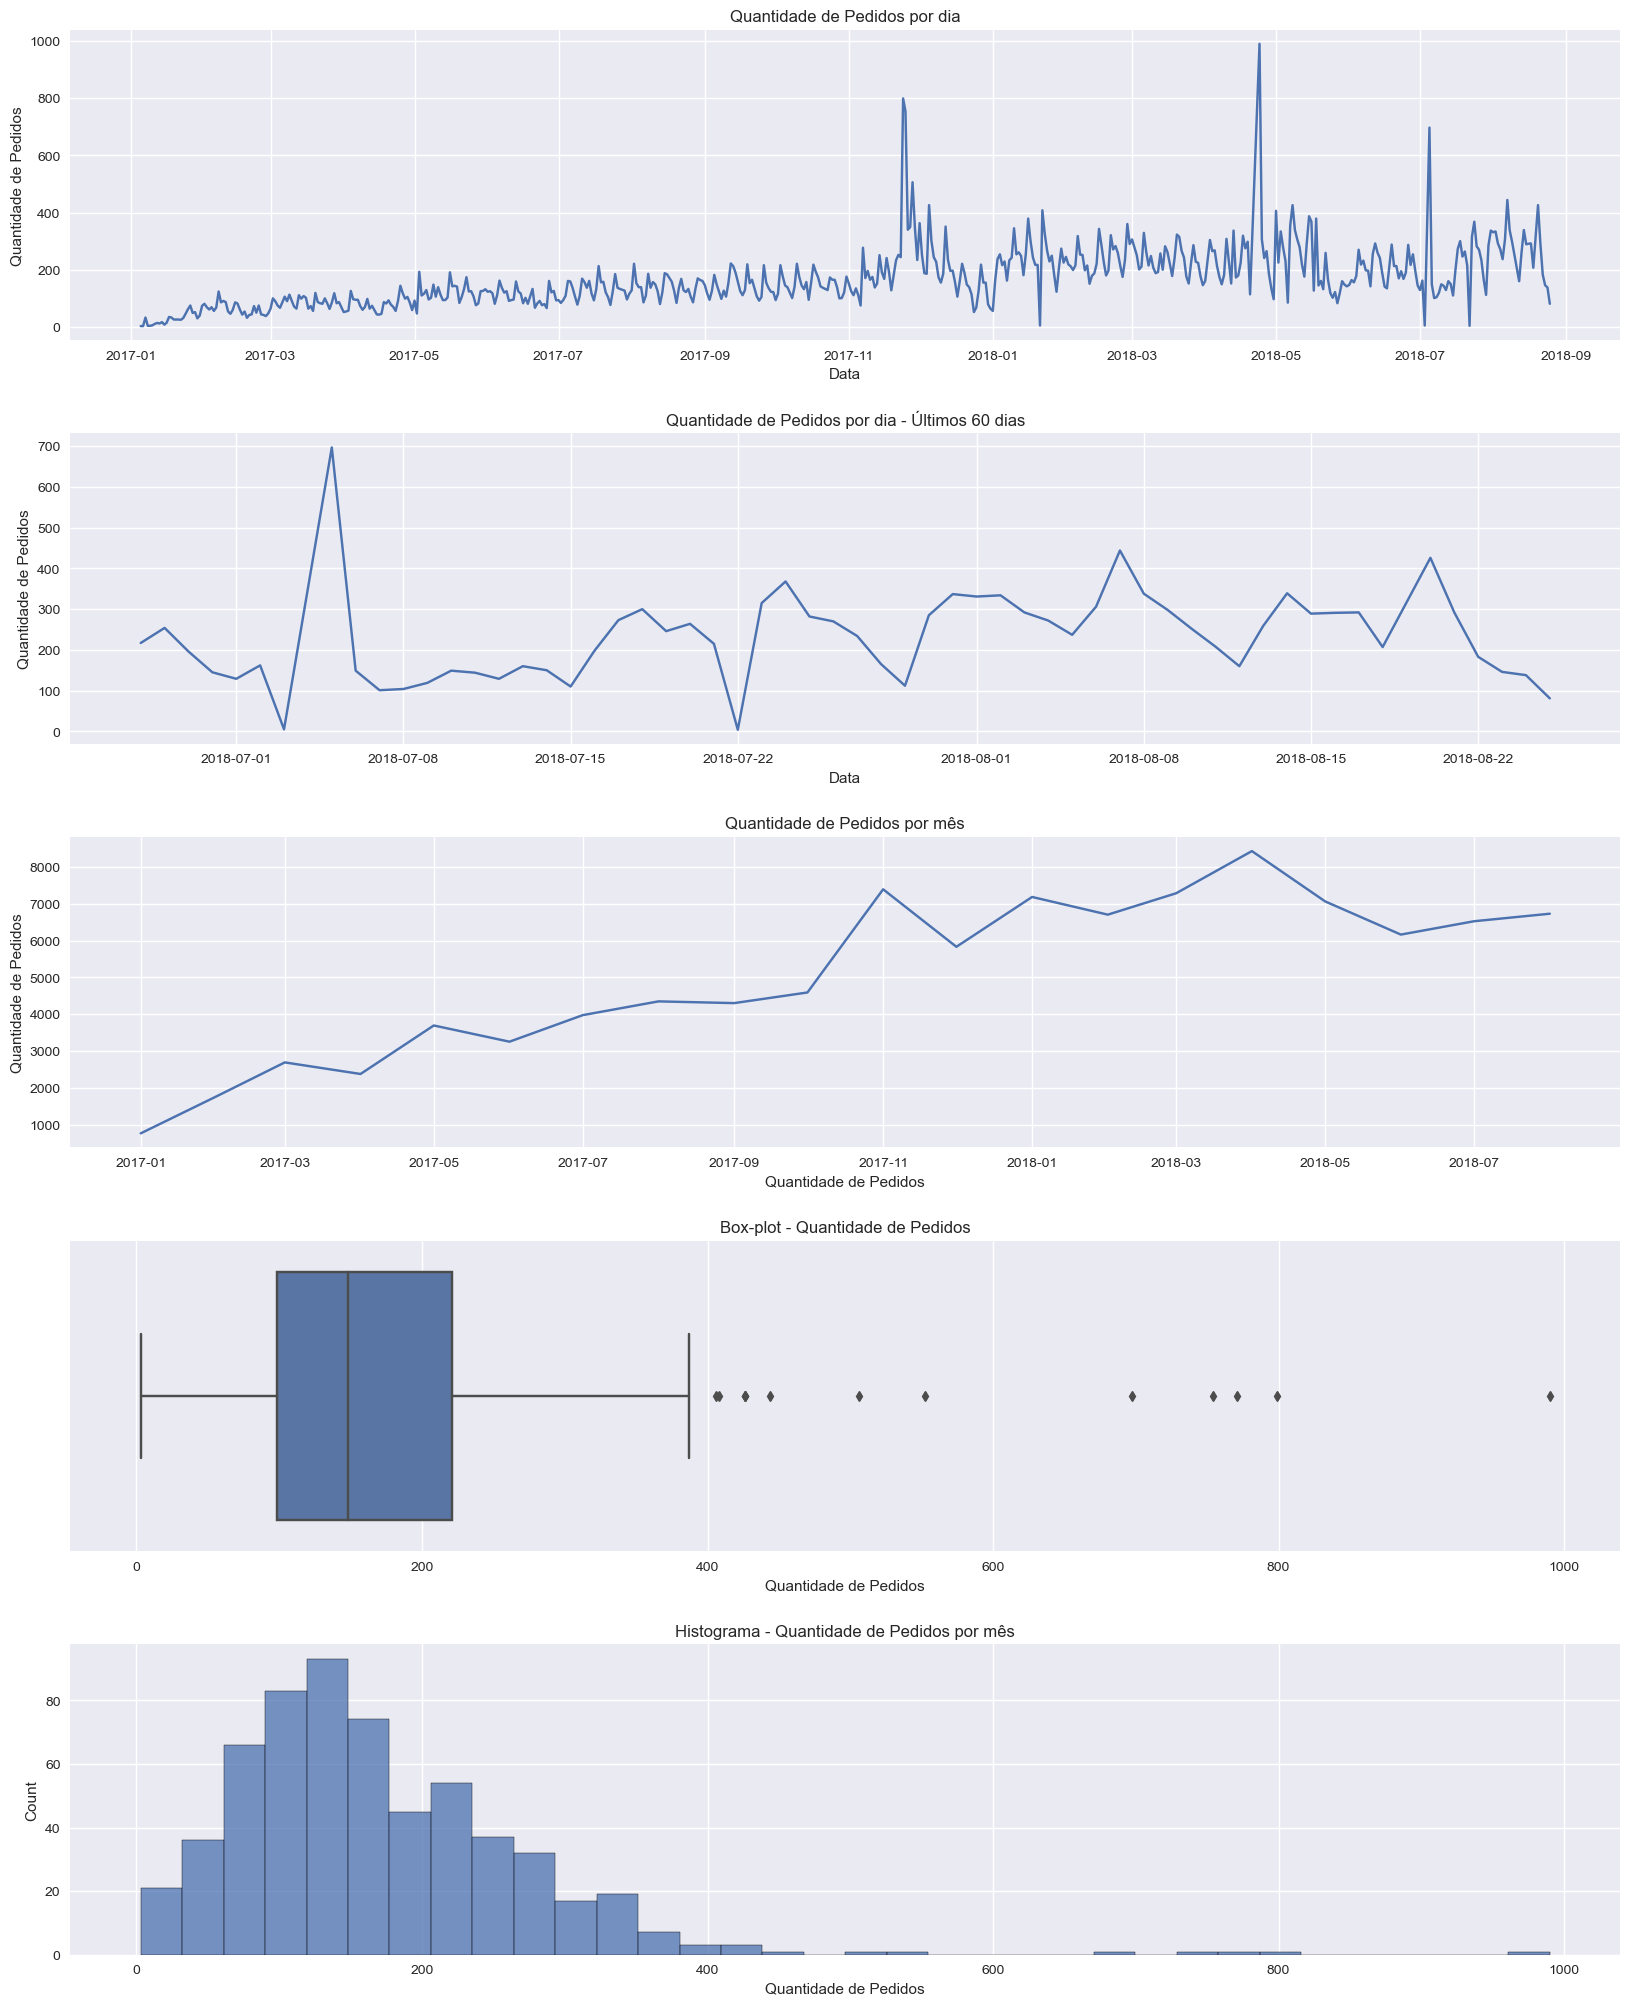

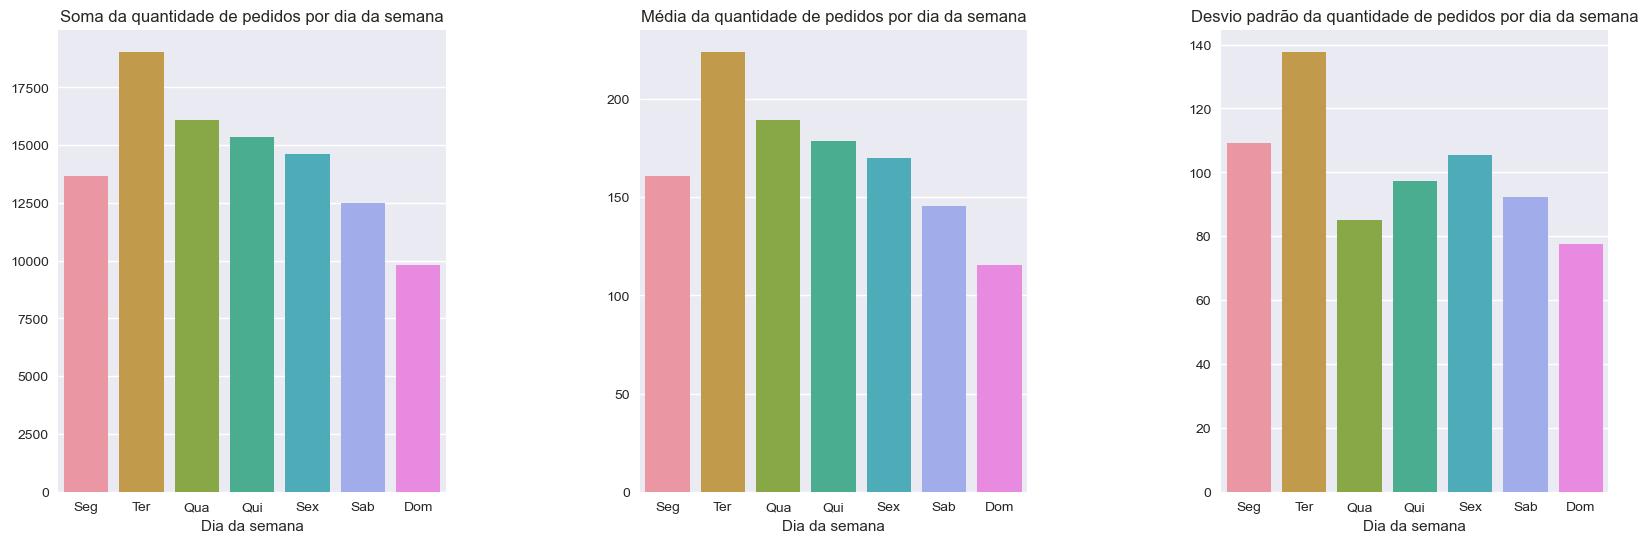

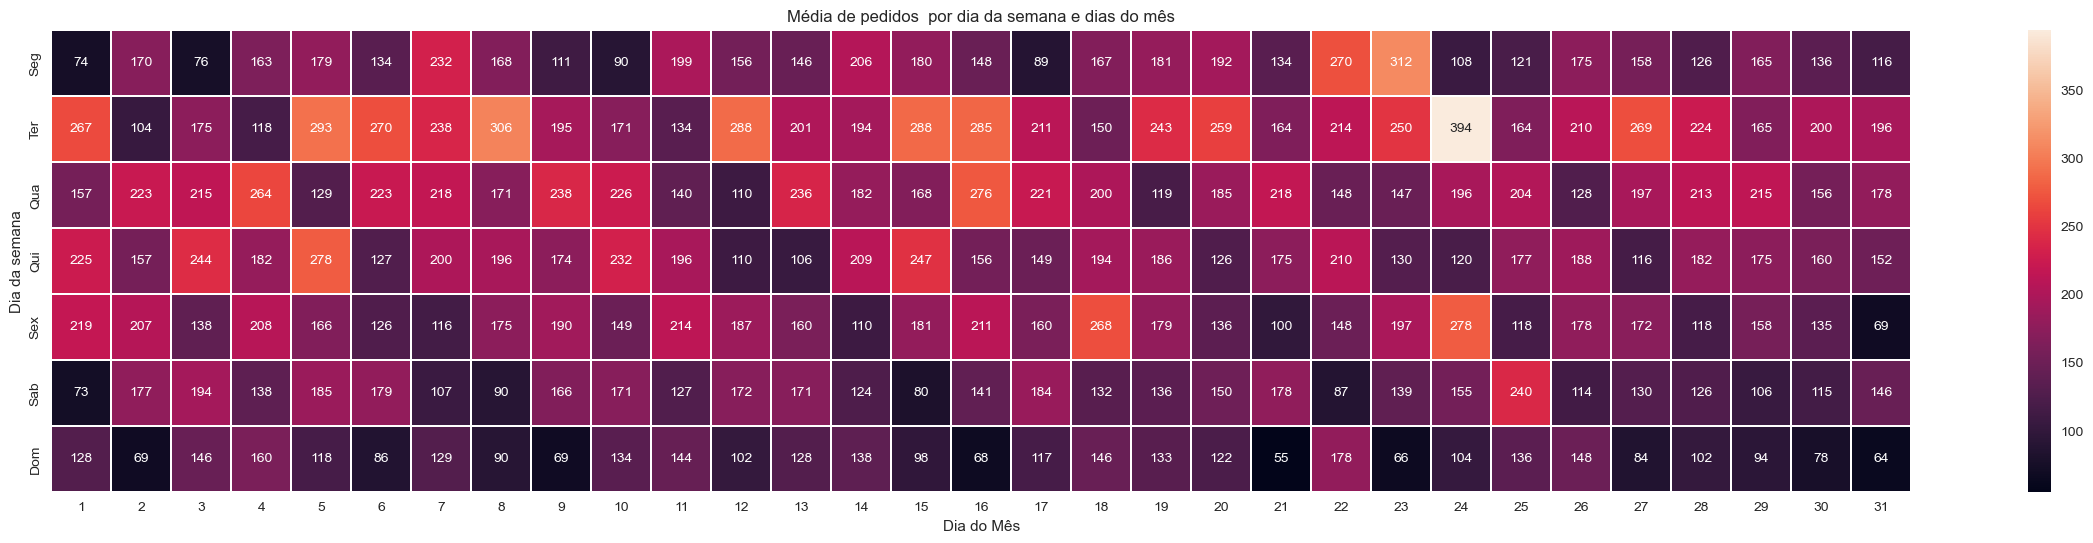

In [9]:
venda_serie_mes = orders_eda[['Mes_ano','Qt_Pedidos']].groupby(['Mes_ano'],as_index=True).sum()

Day_Week_Decribe = orders_eda[["Day_Week","Qt_Pedidos"]].groupby("Day_Week",as_index=False).agg({"Qt_Pedidos":['sum', 'mean','std']})
Day_Week_Decribe.columns = ['Day_Week','quant_ped_sum', 'quant_ped_mean','quant_ped_std']
Day_Week_Decribe['Day_Week'] = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']

Week_x_Month	 = pd.pivot_table(orders_eda, values='Qt_Pedidos', index=['Day_Week'],
                    columns=['Day_Month'], aggfunc=np.mean)
Week_x_Month.index = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']


############################# Grágicos #################################################
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(5,figsize=(20, 25))

sns.lineplot(data=orders_daily["Qt_Pedidos"],ax=axs[0])
axs[0].set_title('Quantidade de Pedidos por dia')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Quantidade de Pedidos')

sns.lineplot(data=orders_daily["Qt_Pedidos"][-60:],ax=axs[1])
axs[1].set_title('Quantidade de Pedidos por dia - Últimos 60 dias')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Quantidade de Pedidos')

sns.lineplot(data=venda_serie_mes["Qt_Pedidos"],ax=axs[2])
axs[2].set_title('Quantidade de Pedidos por mês')
axs[2].set_xlabel('Quantidade de Pedidos')
axs[2].set_ylabel('Quantidade de Pedidos')

sns.boxplot(data=orders_daily,x='Qt_Pedidos',ax=axs[3])
axs[3].set_title('Box-plot - Quantidade de Pedidos')
axs[3].set_xlabel('Quantidade de Pedidos')

sns.histplot(data=orders_daily,x='Qt_Pedidos',ax=axs[4])
axs[4].set_title('Histograma - Quantidade de Pedidos por mês')
axs[4].set_xlabel('Quantidade de Pedidos')
plt.subplots_adjust(hspace=0.3)
plt.show()
#####################################################################################

fig, axs = plt.subplots(1,3,figsize=(20, 6))

sns.barplot(data=Day_Week_Decribe,y="quant_ped_sum",x="Day_Week" ,ax=axs[0])
axs[0].set_title("Soma da quantidade de pedidos por dia da semana")
axs[0].set_xlabel('Dia da semana')
axs[0].set_ylabel('')

sns.barplot(data=Day_Week_Decribe,y="quant_ped_mean",x="Day_Week" ,ax=axs[1])
axs[1].set_title("Média da quantidade de pedidos por dia da semana")
axs[1].set_xlabel('Dia da semana')
axs[1].set_ylabel('')

sns.barplot(data=Day_Week_Decribe,y="quant_ped_std",x="Day_Week" ,ax=axs[2])
axs[2].set_title("Desvio padrão da quantidade de pedidos por dia da semana")
axs[2].set_xlabel('Dia da semana')
axs[2].set_ylabel('')
plt.subplots_adjust(wspace=0.5)
plt.show()

###################################################################################

f, ax = plt.subplots(figsize=(30,6))
sns.heatmap(Week_x_Month,
            annot=True,
            fmt="0.0f",
            linewidths=.5, ax=ax)
ax.set_title("Média de pedidos  por dia da semana e dias do mês")
ax.set_xlabel('Dia do Mês')
ax.set_ylabel('Dia da semana')

plt.show()


In [10]:

# orders_v2 = pd.read_csv("../data/raw/orders_dataset_raw.csv",
#                         #nrows=100,
#                         dtype={'order_item_id': str},
#                         parse_dates   = ['order_approved_at'],usecols=['order_id','order_approved_at']
#                         ) 
# orders_v2['DateCol'] = pd.to_datetime(orders_v2['order_approved_at']).dt.date
# orders_v2['HourCol'] = pd.to_datetime(orders_v2['order_approved_at']).dt.hour
# orders_v2['weekday'] = orders_v2['order_approved_at'].dt.weekday

# OrdersHourWeekday = orders_v2[['order_id','DateCol','HourCol','weekday']].groupby(['DateCol','HourCol','weekday'],as_index=False).count()
# OrdersHourWeekday.rename(columns={'order_id':'Pedidos'},inplace=True)
# OrdersHourWeekdayMean = pd.pivot_table(OrdersHourWeekday.drop(columns=['DateCol']), values='Pedidos', index='HourCol', columns='weekday', aggfunc='mean')


# f, ax = plt.subplots(figsize=(30,12))
# sns.heatmap(OrdersHourWeekdayMean,
#             annot=True,
#             fmt="0.0f",
#             linewidths=.5, ax=ax)
# ax.set_title("Média de pedidos  por dia da semana e Hora do dia")
# ax.set_xlabel('Dia da semana')
# ax.set_ylabel('Hora do dia')

# plt.show()

# sns.boxplot(data=OrdersHourWeekday, x="Pedidos", y="weekday" ,  orient="h")

# OrdersHourWeekday[['HourCol','weekday','Pedidos']].groupby(['HourCol','weekday']).describe()

## Outliers

Essas datas datas podem ser de eventos específicos como:
* Altas em 24 e 25 de 2017/11, Black Friday de 2017.
* Altas em 23 e 24 de 2018/04, final de semana próximo ao dia das mães, também encontrei itens relacionados a Dia do Frete Grátis.
* Para o pico em 2018-07-05 não encontrei nada específico.

Entender essas datas é importante porque são eventos que impactam os pedidos fora de um padrão que possa ser treinado, logo impactando na precisão do mesmo, mas se categorizarmos e planejarmos esses eventos e adiciona-los como caracteristicas do modelo modemos minimizar esses impactos.

c:\Users\chpsi\anaconda3\envs\Forecast\lib\site-packages\ipykernel_launcher.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



,Qt_Pedidos
ds,
2017-11-24,799.0
2017-11-25,754.0
2018-04-23,771.0
2018-04-24,990.0
2018-07-05,697.0


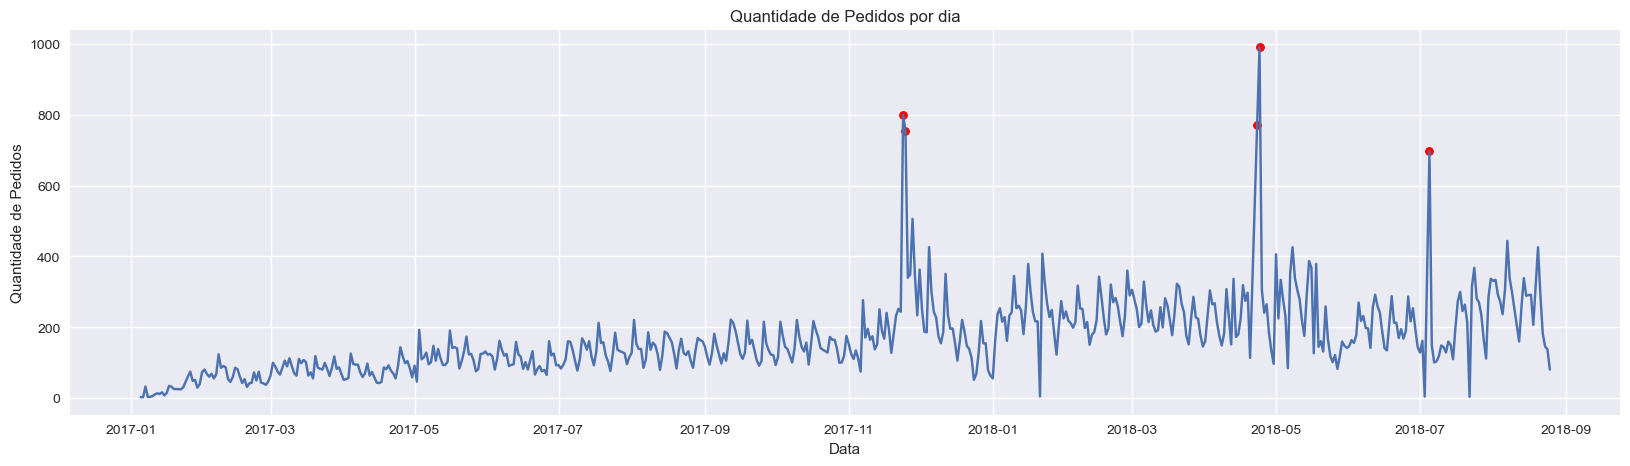

In [11]:
plt.style.use('seaborn')
fig, axs = plt.subplots(1,figsize=(20, 5))

sns.lineplot(data=orders_daily,ax=axs,legend=False,color='green')
sns.scatterplot(y=orders_daily[orders_daily['Qt_Pedidos']>600]["Qt_Pedidos"],
                x=orders_daily[orders_daily['Qt_Pedidos']>600]["Qt_Pedidos"].index,
                ax=axs,
                color="red",
                # size=500,
                legend=False)

axs.set_title('Quantidade de Pedidos por dia')
axs.set_xlabel('Data')
axs.set_ylabel('Quantidade de Pedidos')
# axs.text(x=orders_daily.loc['2017-11-24'].index.values,y=orders_daily.loc['2017-11-24'],s="Texto")
fig.show()
orders_daily[orders_daily['Qt_Pedidos']>600]

# Decomposição

## Testando estacionaridade
Para p < 0,05 é considerado estacionário. No geral a série não atende esse critério em um nível de significância de 5%, mas por bem pouco. Quando fazemos o recorte desse série temporal em duas partes vemos que no mesmo teste a porção mais recente é considereda estacionária, por se tratar do período mais recente vou considerar uma estacionáridade para o futuro dessa série.

In [12]:
print(100*"_")
print(f"Testando estacionaridade geral")
from statsmodels.tsa.stattools import adfuller
X = orders_daily[['Qt_Pedidos']]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

n=300 #Corte dos dados

print(100*"_")
print(f"Testando estacionaridade até os {n} primeiros valores")
X = orders_daily[['Qt_Pedidos']][:n]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

print(100*"_")
print(f"Testando estacionaridade depois dos {n} primeiros valores")

from statsmodels.tsa.stattools import adfuller
X = orders_daily[['Qt_Pedidos']][n:]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))


____________________________________________________________________________________________________
Testando estacionaridade geral
ADF Estatíticas: -2.752063
Valor de P: 0.065454
Valores Críticos:
	1%: -3.442
	5%: -2.867
	10%: -2.569
____________________________________________________________________________________________________
Testando estacionaridade até os 300 primeiros valores
ADF Estatíticas: -2.376885
Valor de P: 0.148367
Valores Críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572
____________________________________________________________________________________________________
Testando estacionaridade depois dos 300 primeiros valores
ADF Estatíticas: -4.724102
Valor de P: 0.000076
Valores Críticos:
	1%: -3.453
	5%: -2.872
	10%: -2.572


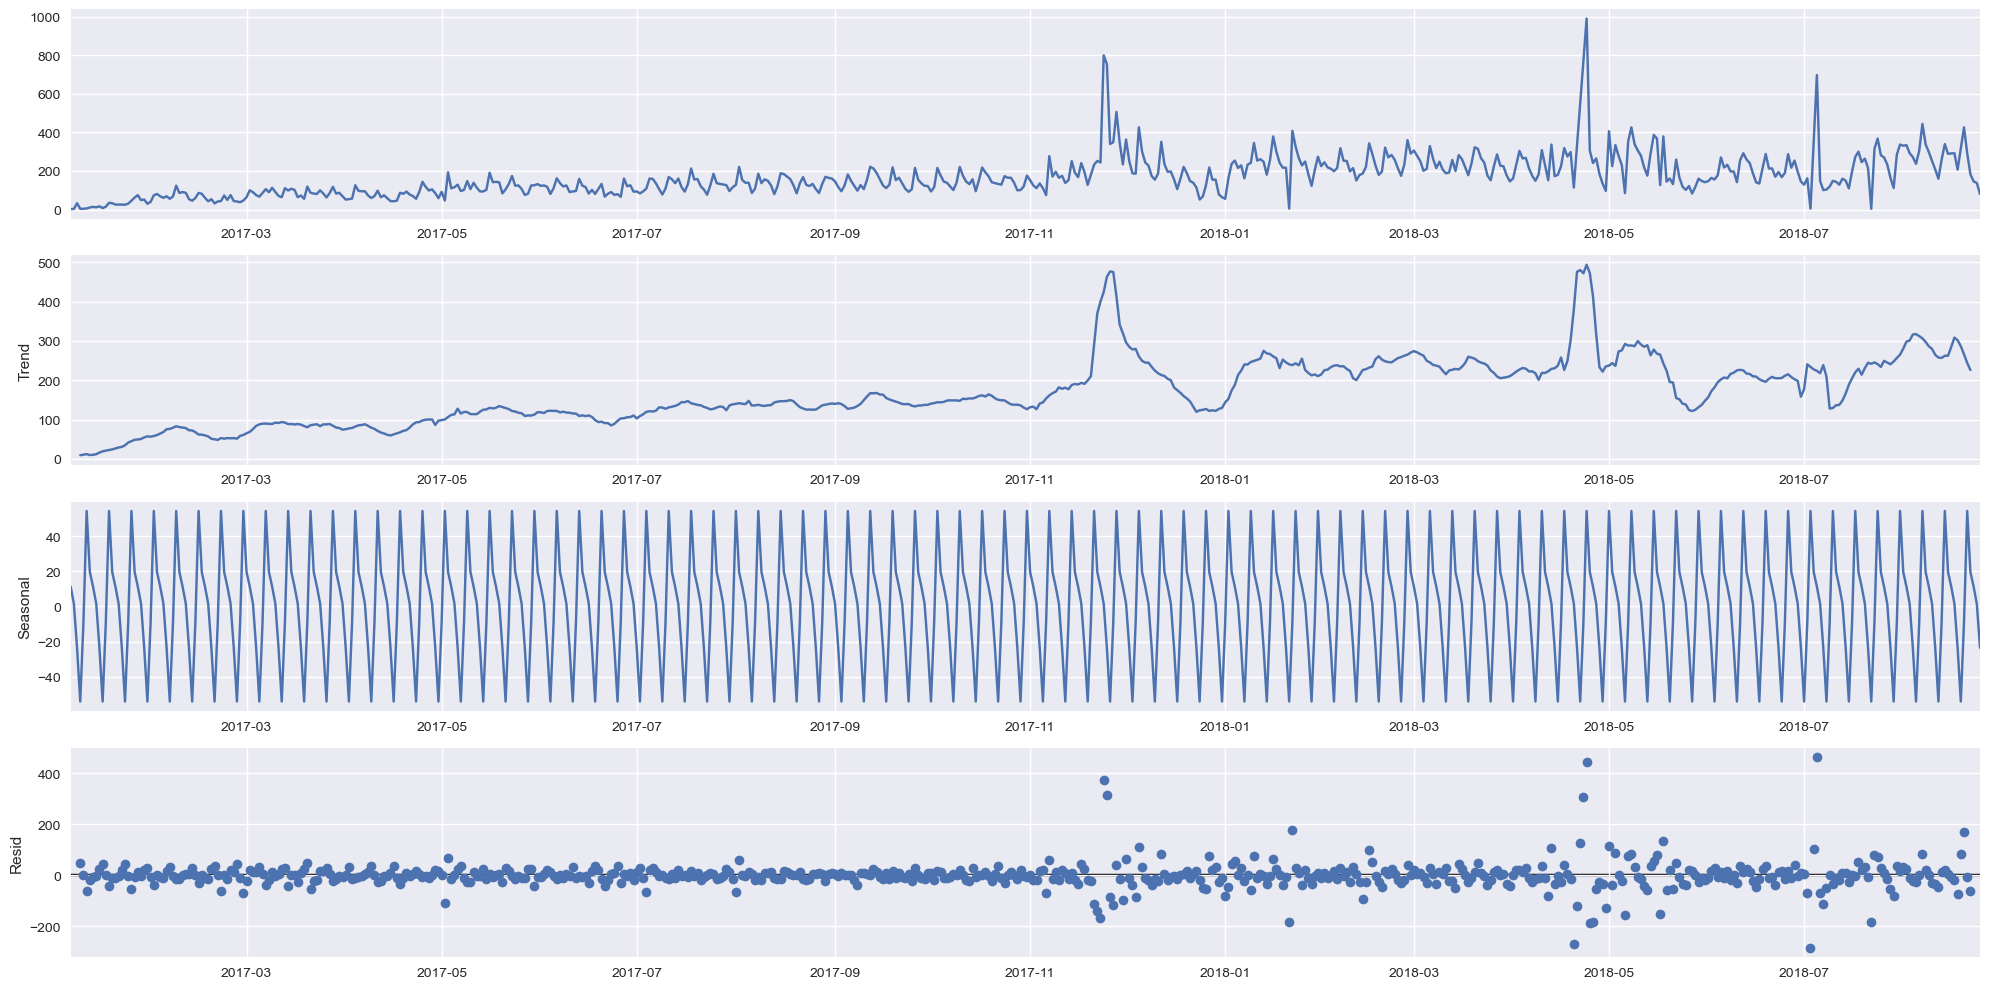

In [13]:
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 20, 10

from statsmodels.tsa.seasonal import seasonal_decompose

# ts_daily.set_index('dia',inplace=True)
decomposition = seasonal_decompose(orders_daily[['Qt_Pedidos']], model='additive')
fig = decomposition.plot()
plt.show()

## Sazonalidade
Aqui se reforça a sazonalidade semanal mostrada anteriormente.

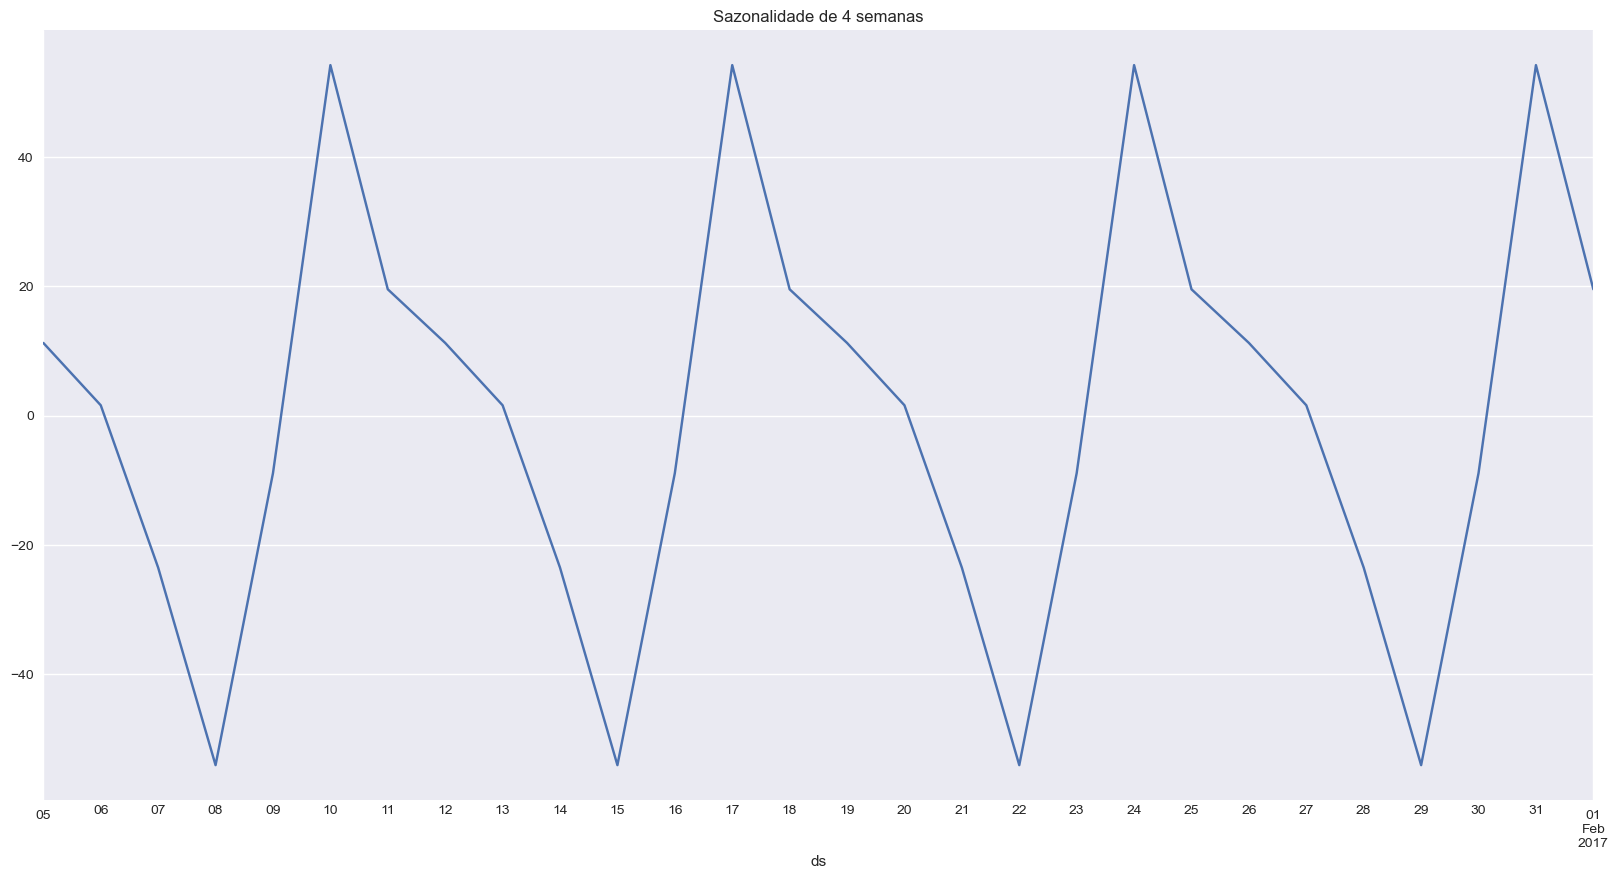

In [14]:
plt.title('Sazonalidade de 4 semanas')
rcParams['figure.figsize'] = 6,3
# fig, axs = plt.subplots(1,figsize=(20, 5))
decomposition.seasonal[:28].plot()

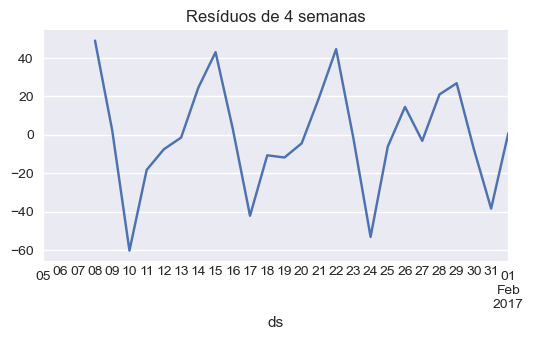

In [15]:
plt.title('Resíduos de 4 semanas')
rcParams['figure.figsize'] = 7,3
decomposition.resid[:28].plot()

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## Autocorrelação

A Autocorrelação (ACF) é uma medida estatística que nos ajuda a entender a relação entre os valores de uma série temporal em diferentes momentos no tempo, mede o quanto o momento atual é correlacionado ao conjunto de momentos imediatamente anteriores.

Na nossa série o ela se mostrar superior a 0.5 em até dois dias e em 7 dias, e superior a 0.3 em até duas semanas.


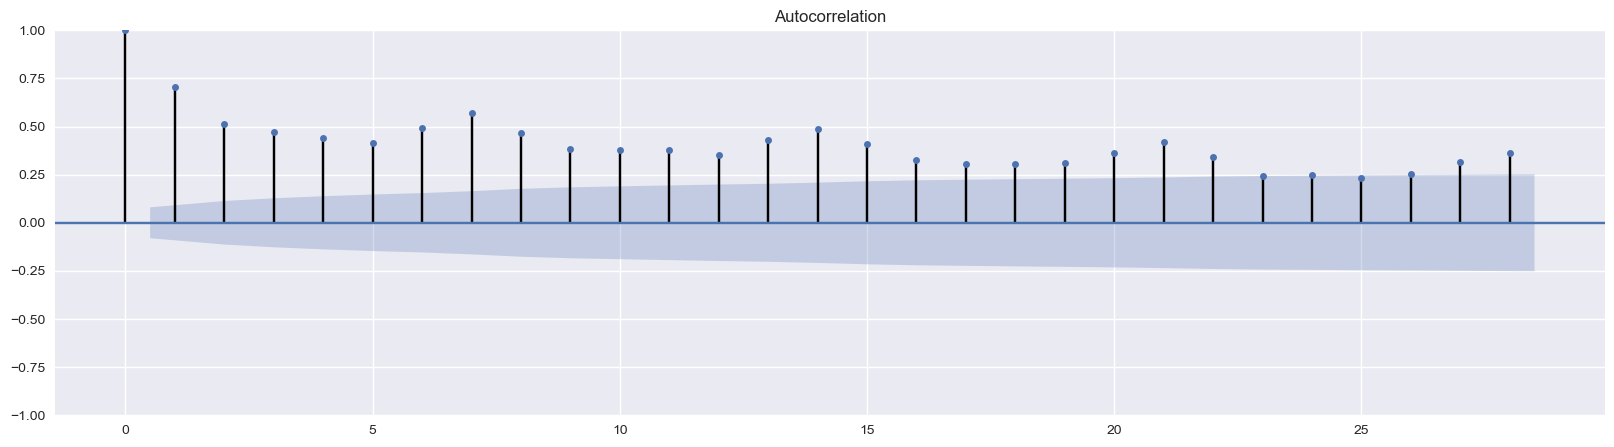

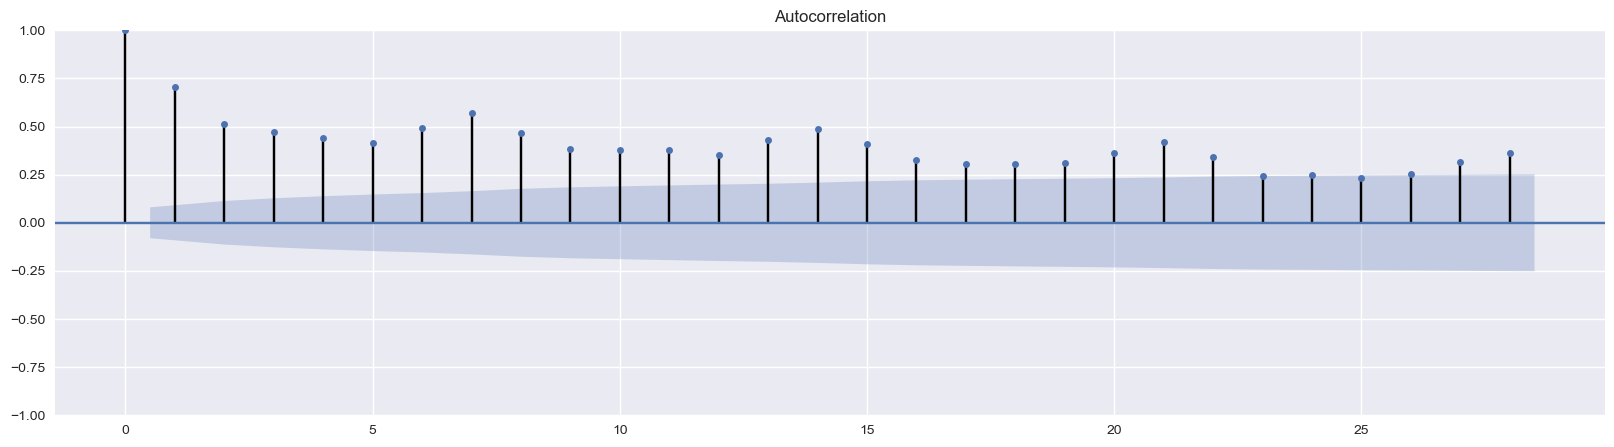

In [17]:
rcParams['figure.figsize'] =  20, 5
plot_acf(orders_daily[['Qt_Pedidos']][:],lags=28)


## Autocorrelação Parcial

A Autocorrelação Parcial (PACF) é uma medida estatística que nos ajuda a entender a relação direta entre duas observações em uma série temporal, removendo a influência das observações intermediárias, isto é, ao contrário da ACF ela não considera o conjunto de itens imediatamente anteriores e sim a relação do momento atual com outro anterior em uma distância especifica.
Na nossa série, com exceção ao dia anterior com quase 0.75 temos os dias 6 e 7 proximos a 0.25, todos os outros são abaixo disso.

c:\Users\chpsi\anaconda3\envs\Forecast\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



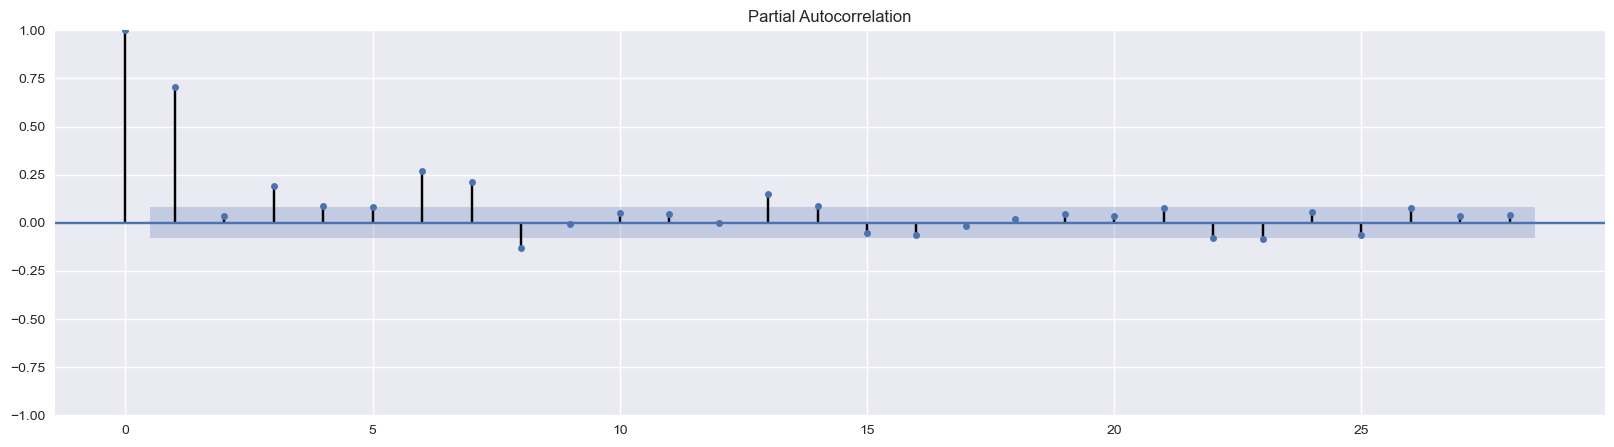

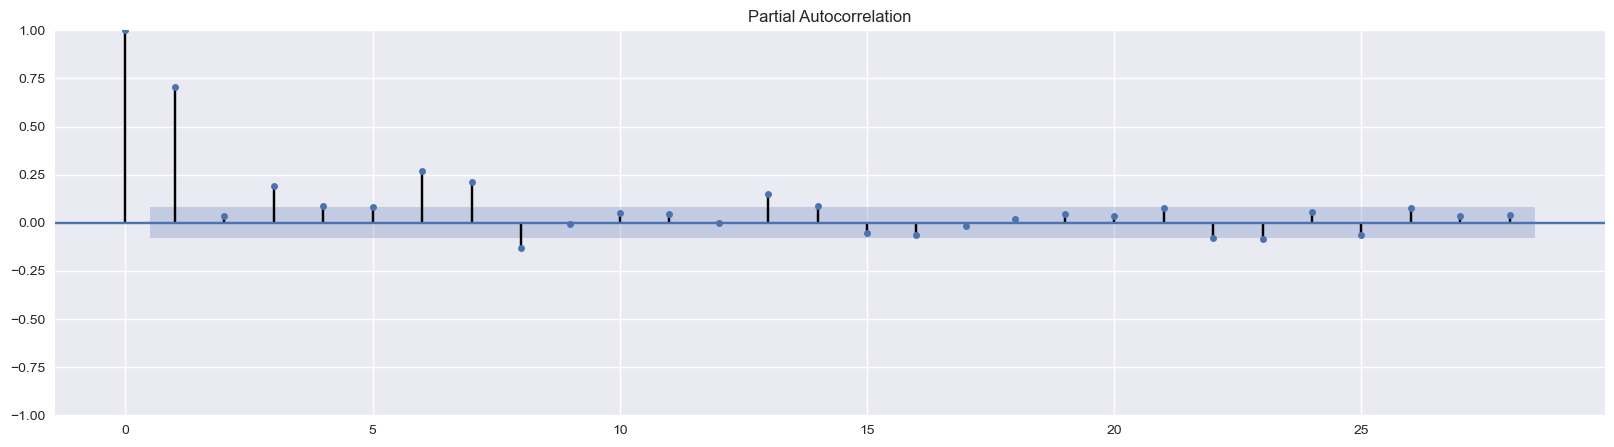

In [18]:
plot_pacf(orders_daily[['Qt_Pedidos']][:],lags=28)

# Treino e teste

In [46]:
len_teste = 30
train = orders_daily[:len(orders_daily)-len_teste]
teste = orders_daily[-len_teste:]


print(f"Treino com {train['Qt_Pedidos'].count()} valores e teste com {teste['Qt_Pedidos'].count()}")

Treino com 568 valores e teste com 30


In [47]:
train_prophet = train['Qt_Pedidos'].reset_index()
train_prophet.columns = ['ds', 'y']


# Modelagem Prophet

In [21]:
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation,performance_metrics
import itertools
# from prophet.plot import add_changepoints_to_plot , plot_cross_validation_metric


Funções

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def MetricsTable(ModelName,X,Y):
  df = pd.DataFrame(data = {'Model': ['Model'],
                                      'R2_score': [1.0],
                                      'MAE':[1.0],
                                      'MSE': [1.0],
                                      'RMSE':[1.0]})
  df = df.drop([0])
  R2_score = r2_score(X,Y)
  MAE = mean_absolute_error(X,Y)
  MSE = mean_squared_error(X,Y)
  RMSE = mean_squared_error(X,Y,squared=False)
  df.loc[len(df.index)] = [ModelName, R2_score, MAE,MSE,RMSE]  
  return df

def extract_params(pr_model):
    return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

def ForecastPlotProphet(df_teste,df_train,df_predict_raw,
                        figPath=None,
                        HistorySlice=450,title='Previsto x Validação'):
    df_predict = df_predict_raw[['ds','yhat']].set_index('ds')
    df_predict.columns = ['Previsto']
    rcParams['figure.figsize'] = 30, 5
    plt.style.use('fivethirtyeight')
    plt.figure()  
    plt.title(title)
    plt.plot(df_predict, label='Previsão', color = 'red', linewidth = 2)
    plt.plot(df_train[HistorySlice:].append(df_teste[:1]), label='Histórico', color = 'gray', linewidth = 2)
    plt.plot(df_teste, label='Validação', color = 'blue', linewidth = 2)
    plt.fill_between(df_teste.index,df_predict_raw['yhat_lower'],df_predict_raw['yhat_upper'], alpha=0.5)
    plt.xlabel("Período")
    plt.legend(loc='best')
    if figPath == None:
      figPath =  str(Path(Path.cwd()).parent.joinpath("images\Forecast.png"))
      # figPath = "C:\WIMYD\MasterOfDices\images\Forecast.png"
    plt.savefig(figPath, dpi=150)
    mlflow.log_artifact(figPath)
    plt.show()
    MetricsTable('Prophet',df_teste,df_predict)
    # print(MetricsTable('prophet',df_teste.values,df_predict.values))
    # return figPath,str(Path(Path.cwd()).parent.joinpath("imagens\Forecast.png"))

## Modelo Inicial

### Criando experimento

In [ ]:
mlflow.set_tracking_uri(Path(Path.cwd()).parent.joinpath(
    "models").joinpath("mlruns").as_uri())

# Create an experiment name, which must be unique and case sensitive
experiment_id = mlflow.create_experiment(
    "Forecast_Initial",
    # artifact_location=diretorio_anterior.joinpath("models").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

In [23]:
condaEnv = {"name": "Forecast",
                "channels": ["conda-forge"],
                "dependencies": [ "python=3.7", "prophet",
                    {"pip": [
                            "pystan",
                            "mlflow",
                            "jupyterlab",
                            "plotly",
                            "seaborn",
                            "statsmodels",
                            "scikit-learn",
                            "ipywidgets"
                        ],
                    },
                ],
            }

### Treino

INFO:prophet:Making 36 forecasts with cutoffs between 2017-03-09 00:00:00 and 2018-07-12 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]

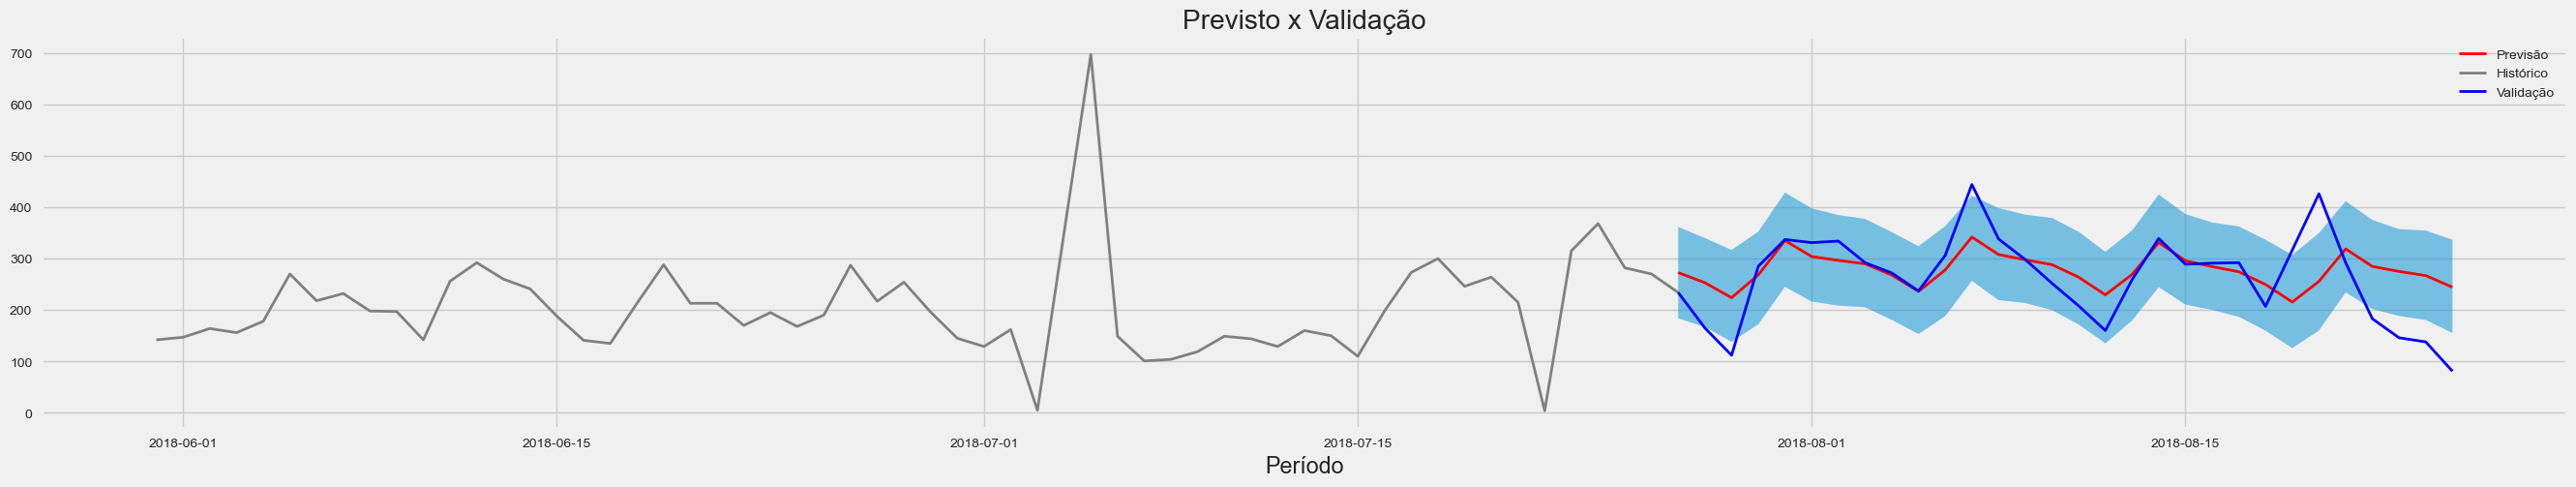

Métrica de Treino com Validação cruzada
{'mse': 8591.79199267423, 'rmse': 90.54778647734052, 'mae': 54.53748636504675, 'mape': 0.6755816959715251, 'mdape': 0.21019032661372056, 'smape': 0.28627485483189097, 'coverage': 0.5494017094017094}


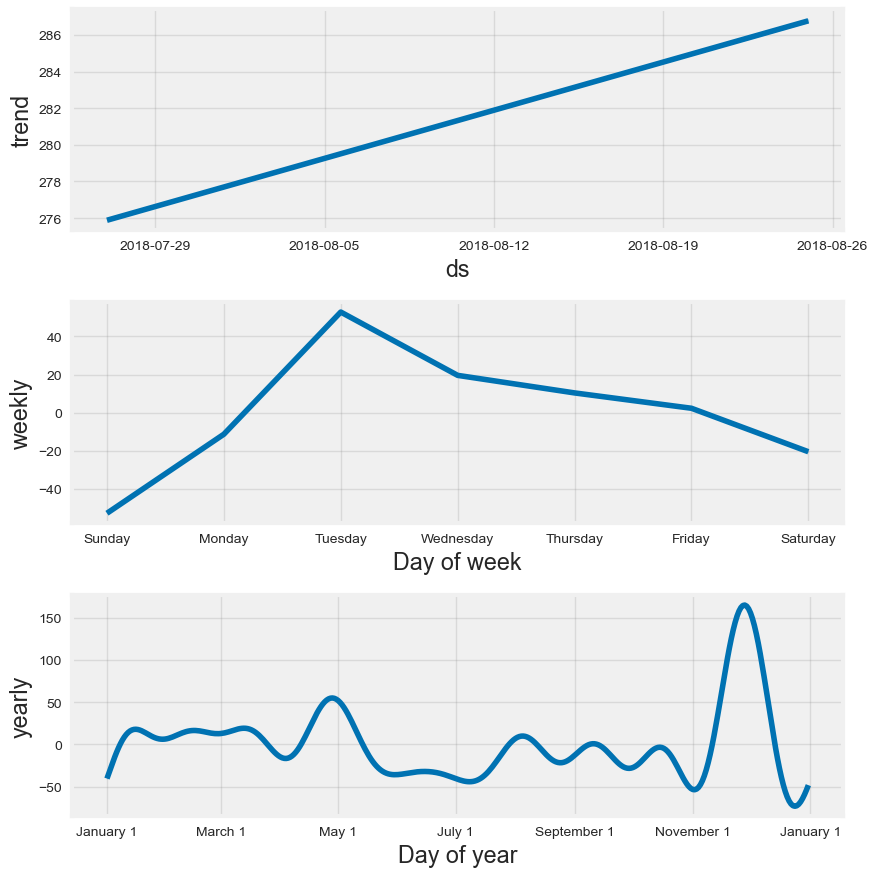

In [24]:
prophet_model = Prophet(seasonality_mode='additive',
            weekly_seasonality = True,
            daily_seasonality=False,
            changepoint_range=0.7,   #Define o intervalo dos dados de treinamento que serão utilizados 				 
                                               #para rastrear pontos de mudança
            changepoint_prior_scale = 0.01,
            yearly_seasonality = 10,
            seasonality_prior_scale=1
            )
#Direcionando para ele  salvar os dados na pasta Models
mlflow.set_tracking_uri(Path(Path.cwd()).parent.joinpath("models").joinpath("mlruns").as_uri())
with mlflow.start_run(run_name="Forecast_Initial") as run:
    prophet_model.fit(train_prophet)

    mlflow.log_params(extract_params(prophet_model))
    cv_results = cross_validation( prophet_model, initial = '56 days', period = '14 days', horizon = '14 days' )
        
    # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
    cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
    metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
    average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
    mlflow.log_metrics(average_metrics)
    model_info = mlflow.prophet.log_model(prophet_model, "prophet-model",conda_env=condaEnv)
    future = prophet_model.make_future_dataframe(periods=len(teste),
                                 #freq='D',
                                 include_history=False)
    predictions = prophet_model.predict(future)

    figPath =Path(Path.cwd()).parent.joinpath("images\Components.png")
    ForecastPlotProphet(df_teste=teste,df_train=train,df_predict_raw=predictions,HistorySlice=int(len(train)*0.90))
    print("Métrica de Treino com Validação cruzada")
    print(average_metrics)
    plt.figure()  
    fig = prophet_model.plot_components(predictions)
    fig.savefig(figPath, dpi=150)
    mlflow.log_artifact(figPath)
    mlflow.end_run()
    
# Load saved model
# prophet_model_saved = mlflow.pyfunc.load_model(model_info.model_uri)
# predictions = prophet_model_saved.predict(future)

In [170]:
# from prophet.plot import plot_cross_validation_metric
# plot_cross_validation_metric(cv_results , metric='mae')

## Otimização de parâmetros

### Criando experimento

In [178]:

diretorio_anterior = Path(Path.cwd()).parent

# Create an experiment name, which must be unique and case sensitive
experiment_id = mlflow.create_experiment(
    "Forecast Otimização de parâmetros",
    #artifact_location=diretorio_anterior.joinpath("models").joinpath("mlruns").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Name: Forecast Otimização de parâmetros
Experiment_id: 1
Artifact Location: file:///c:/WIMYD/ForecastSales/models/mlruns/1
Tags: {'priority': 'P1', 'version': 'v1'}
Lifecycle_stage: active
Creation timestamp: 1687060010965


### Treino de Otimização de parâmetros

In [ ]:

param_grid = {'changepoint_range':[1,0.5],
                           'changepoint_prior_scale': [0.06,0.08,0.1,0.5,1],
                           'yearly_seasonality':[2,5,10],
                           'seasonality_prior_scale': [0.1,1.5],
                           'daily_seasonality':[True,False]
              } #216 combinações de hiperpametros

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
# mlflow.set_tracking_uri(Path(Path.cwd()).parent.joinpath("models").as_uri())
# Use cross validation to evaluate all parameters
for i in range(len(all_params)):
    with mlflow.start_run(experiment_id="1", #experiment_id=experiment.experiment_id,
                          run_name="Forecast_"+str(i)) as run:
        prophet_model = Prophet(weekly_seasonality = True, seasonality_mode ='additive', **all_params[i]).fit(train_prophet)  # Fit model with given params

        mlflow.log_params(extract_params(prophet_model))
        cv_results = cross_validation(
                                    prophet_model,
                                    initial = '56 days',
                                    period = '14 days' ,
                                    horizon = '14 days' )
            
        # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
        cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
        metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
        average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
        mlflow.log_metrics(average_metrics)
        model_info = mlflow.prophet.log_model(prophet_model, "prophet-model",conda_env=condaEnv)        
        future = prophet_model.make_future_dataframe(periods=len(teste),
                                    #freq='D',
                                    include_history=False)
        predictions = prophet_model.predict(future)
        figPath =Path(Path.cwd()).parent.joinpath("images\Components.png")
        ForecastPlotProphet(df_teste=teste,df_train=train,df_predict_raw=predictions,HistorySlice=int(len(train)*0.90))
        print("Métrica de Treino com Validação cruzada")
        print(average_metrics)
        print(MetricsTable('Models',teste['Qt_Pedidos'].values,predictions['yhat']))
        plt.figure() 
        fig = prophet_model.plot_components(predictions)
        fig.savefig(figPath, dpi=150)
        mlflow.log_artifact(figPath)
        mlflow.end_run()

## Tabela com as metricas de todos os modelos

In [29]:
experiment_id = "1"
#run_id = "1"

metrics_exp = mlflow.search_runs(
    experiment_ids=experiment_id,
    run_view_type=mlflow.entities.ViewType.ALL,
    #run_ids=[run_id],
)

df_exp = pd.DataFrame(metrics_exp)
Top10_Models = df_exp[['run_id','tags.mlflow.runName','start_time',
       'end_time', 'metrics.mse', 'metrics.mdape', 'metrics.mape',
       'metrics.rmse', 'metrics.coverage', 'metrics.mae', 'metrics.smape',
       'params.changepoint_range','params.seasonality_prior_scale', 'params.yearly_seasonality', 'params.daily_seasonality',
       'params.weekly_seasonality', 'params.changepoint_prior_scale']].sort_values('metrics.mae').head(10)

Top10_Models

,run_id,tags.mlflow.runName,start_time,end_time,metrics.mse,metrics.mdape,metrics.mape,metrics.rmse,metrics.coverage,metrics.mae,metrics.smape,params.changepoint_range,params.seasonality_prior_scale,params.yearly_seasonality,params.daily_seasonality,params.weekly_seasonality,params.changepoint_prior_scale
4,81fb25c0596a42c29b984234fb309547,Forecast_0,2023-06-19 02:31:09.830000+00:00,2023-06-19 02:32:13.343000+00:00,8204.080902,0.225313,0.622860,88.202374,0.506325,53.755980,0.284183,1,0.1,10,True,True,0.06
92,bea612538a7244f48741af644e017f5a,Forecast_128,2023-06-18 05:59:55.474000+00:00,2023-06-18 06:00:46.824000+00:00,8204.080902,0.225313,0.622860,88.202374,0.505726,53.755980,0.284183,1,0.1,10,True,True,0.06
139,86ddede41cb448eab7d4bf59e0ea8c4b,Forecast_81,2023-06-18 05:15:27.414000+00:00,2023-06-18 05:16:13.479000+00:00,8305.934486,0.226041,0.634001,88.778606,0.514615,54.090510,0.286301,1,0.1,10,False,True,0.04
142,8e3d057bacfe48a2bec0ac9d7547e941,Forecast_78,2023-06-18 05:12:50.316000+00:00,2023-06-18 05:13:36.300000+00:00,8280.927508,0.228441,0.628595,88.686668,0.505128,54.093192,0.283178,1,0.5,10,True,True,0.04
116,7a63e8f15c284dfdb892d93f4298b2b7,Forecast_104,2023-06-18 05:36:26.711000+00:00,2023-06-18 05:37:15.951000+00:00,8253.242943,0.228357,0.630491,88.505199,0.504530,54.114735,0.286005,1,0.1,10,True,True,0.05
211,608ee11b1f5b426ebaad146221ed153a,Forecast_9,2023-06-18 04:19:02.233000+00:00,2023-06-18 04:19:40.947000+00:00,8363.183242,0.226348,0.636123,89.123436,0.519487,54.300571,0.286443,0.7,0.1,10,False,True,0.04
20,9d13bc1f5f51428e8e479a18402427f5,Forecast_200,2023-06-18 07:19:46.820000+00:00,2023-06-18 07:20:44.884000+00:00,8330.946782,0.228717,0.627456,88.940867,0.507863,54.350743,0.287696,0.5,0.1,10,True,True,0.06
164,90e621e7d22f4e15a8eddee4712ed733,Forecast_56,2023-06-18 04:54:13.169000+00:00,2023-06-18 04:54:58.219000+00:00,8313.347412,0.226960,0.628334,88.859135,0.495043,54.567814,0.290096,0.7,0.1,10,True,True,0.06
214,6f1da934a5254644bdde4980eb994949,Forecast_6,2023-06-18 04:17:01.381000+00:00,2023-06-18 04:17:40.376000+00:00,8356.360091,0.225883,0.630786,89.166778,0.517009,54.590241,0.290344,0.7,0.5,10,True,True,0.04
170,5a1573c9ac5a4f9393a37a28256e5a00,Forecast_50,2023-06-18 04:49:26.019000+00:00,2023-06-18 04:50:09.898000+00:00,9214.633538,0.203529,0.593046,93.918782,0.613761,54.675809,0.276519,0.7,0.1,3,True,True,0.06


In [30]:
Top10_Models[0:1]

,run_id,tags.mlflow.runName,start_time,end_time,metrics.mse,metrics.mdape,metrics.mape,metrics.rmse,metrics.coverage,metrics.mae,metrics.smape,params.changepoint_range,params.seasonality_prior_scale,params.yearly_seasonality,params.daily_seasonality,params.weekly_seasonality,params.changepoint_prior_scale
4,81fb25c0596a42c29b984234fb309547,Forecast_0,2023-06-19 02:31:09.830000+00:00,2023-06-19 02:32:13.343000+00:00,8204.080902,0.225313,0.62286,88.202374,0.506325,53.75598,0.284183,1,0.1,10,True,True,0.06
